### 导入必要包

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime

print('GPU is', 'available' if tf.test.is_gpu_available() else 'Not available')

GPU is available


In [2]:
tf.__version__

'2.0.0'

### 超参数设置
NCLASSES: 分类的类别数  
HEIGHT: 根据模型输入尺寸要求更改，VGG 采用(batch_size, 224, 224, 3)  
WIDTH: 根据模型输入尺寸要求更改，VGG 采用(batch_size, 224, 224, 3)  
NUM_CHANNELS: 根据模型输入尺寸要求更改，VGG 采用(batch_size, 224, 224, 3)  
BATCH_SIZE: 批次大小

In [3]:
NCLASSES = 2
HEIGHT = 224
WIDTH = 224
NUM_CHANNELS = 3
BATCH_SIZE = 50

### Keras预装载模型

In [4]:
base_model = tf.keras.applications.VGG16(input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), include_top=False, weights='imagenet')
base_model.trainable = False

print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 设置全连接层  
GlobalAveragePooling2D 详述见前面介绍

In [5]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 定义需求函数

In [6]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=NUM_CHANNELS)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image /= 255.0

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def get_file(file_dir):
    labels = []
    images = []
    for root, _, files in os.walk(file_dir):
        for name in files:
            cls_name = name.split('.')[0]
            if cls_name == 'cat':
                labels.append(0)
                images.append(file_dir + name)
            else:
                labels.append(1)
                images.append(file_dir + name)

    temp = np.array([images, labels])
    temp = temp.transpose()
    np.random.shuffle(temp)
    image_list = list(temp[:, 0])
    label_list = list(temp[:, 1])
    label_list = [int(float(i)) for i in label_list]
    
    return image_list, label_list

### 数据读取

In [7]:
file_dir = 'data/train/'
files, categories = get_file(file_dir)

path_dataset = tf.data.Dataset.from_tensor_slices(files)
image_dataset = path_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(categories, tf.int64))
image_label_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

dataset = image_label_dataset.repeat().shuffle(1000).batch(BATCH_SIZE).prefetch(1)

### 模型 compile

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 设置回调

In [9]:
log_dir = os.path.join(
    'logs2.x',
    'train',
    'plugins',
    'profile',
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

checkpoint_path = './keras_checkpoint2.x/cats_vs_dogs.{epoch:02d}.ckpt'

if not os.path.exists('./keras_checkpoint2.x'):
    os.mkdir('./keras_checkpoint2.x')


callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                         histogram_freq=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_weights_only=True,
                                       verbose=0,
                                       save_freq='epoch'),
]

### 开始训练

In [10]:
train_history = model.fit(dataset,
                          epochs=20,
                          steps_per_epoch=20,
                          callbacks=callbacks,
                          verbose=1)

Train for 20 steps
Epoch 1/20
20/20 [==============================] - 35s 2s/step - loss: 0.7965 - accuracy: 0.5870
Epoch 2/20
20/20 [==============================] - 20s 986ms/step - loss: 0.4286 - accuracy: 0.8000
Epoch 3/20
20/20 [==============================] - 21s 1s/step - loss: 0.3388 - accuracy: 0.8690
Epoch 4/20
20/20 [==============================] - 20s 977ms/step - loss: 0.2689 - accuracy: 0.8860
Epoch 5/20
20/20 [==============================] - 21s 1s/step - loss: 0.2580 - accuracy: 0.8890
Epoch 6/20
20/20 [==============================] - 20s 1s/step - loss: 0.2334 - accuracy: 0.9030
Epoch 7/20
20/20 [==============================] - 22s 1s/step - loss: 0.2449 - accuracy: 0.9060
Epoch 8/20
20/20 [==============================] - 20s 1s/step - loss: 0.2340 - accuracy: 0.9060
Epoch 9/20
20/20 [==============================] - 22s 1s/step - loss: 0.2621 - accuracy: 0.8920
Epoch 10/20
20/20 [==============================] - 20s 1s/step - loss: 0.2434 - accuracy: 0

### 可视化参数

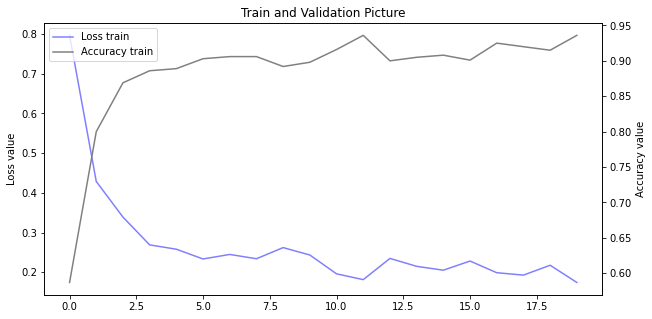

In [11]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(train_history.history['loss'], color=(0.5, 0.5, 1.0), label='Loss train')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line2, = ax2.plot(train_history.history['accuracy'], color=(0.5, 0.5, 0.5), label='Accuracy train')
plt.legend(handles=(line1, line2), loc='best')
plt.show()

### 预测可视化
**利用TensorFlow2.0 高阶API keras 迁移学习未使用序列化模型，所以不能使用 model.predict_classes()，应使用 model.predict()**

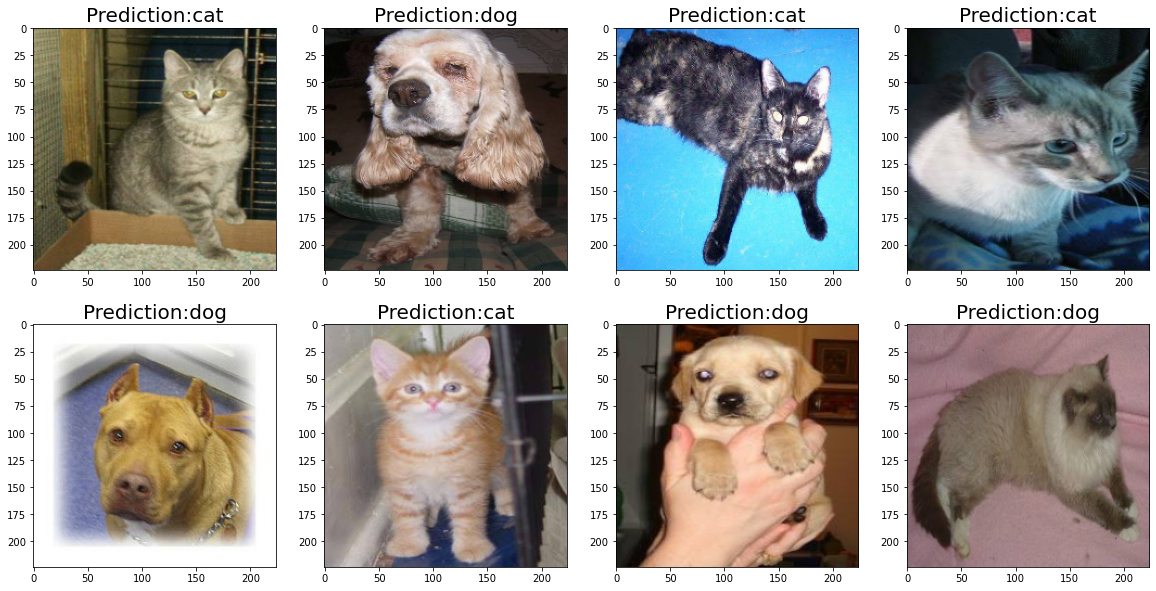

In [33]:
file_i = np.random.randint(12500, size=(1, 8))
filepath = []
plt_images = []
pre_images = []
root_dir = 'data/test1/'
for i in range(file_i.shape[1]):
    filepath.append(root_dir + str(file_i[0][i]) + '.jpg')
    
for path in filepath:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32)
    IMG = img.copy()
    plt_images.append(IMG)
    del IMG
    pre_images.append(img)

image_batch = np.array(pre_images)
prob = model.predict(image_batch)
max_index = np.argmax(prob, 1)

fig = plt.gcf()
fig.set_size_inches(20, 10)
for i in range(8):
    if max_index[i] == 0:
        cls_name = 'cat'
    else:
        cls_name = 'dog'
    ax = plt.subplot(2, 4, 1 + i)
    ax.imshow(plt_images[i].astype('uint8'), cmap='binary')
    title = 'Prediction:' + cls_name
    ax.set_title(title, fontsize=20)
plt.show()